In a dataset, missing values (also called null values or NA values) are points of data that were not recorded, not collected, or are otherwise unavailable. Essentially, these are “blanks” in the dataset where a value is expected but is absent. Possible reasons for missing values include errors in data entry, incomplete responses to surveys, dropped sensor readings in real-time monitoring, or simply because certain information was not applicable to a particular observation.

Because missing values can introduce bias or lead to incorrect conclusions if handled improperly, they are often a key focus during data cleaning and preprocessing. Common ways to handle missing values include:

- Deletion (removing entire rows or columns that contain too many missing values).

- Imputation (replacing missing values with estimated values, such as the mean or median).

- Model-based methods (using algorithms to predict and fill in missing values).

When working with numerical data, missing values can bias analyses or reduce the training data size. The choice of how to handle missing values depends on the nature of your dataset, how many observations are missing, and the relationship between missingness and other variables. Below are a few common approaches:

1. Deletion

    - Listwise (complete-case) deletion: Remove any row with a missing value. This is straightforward, but if the proportion of missing values is large, it can seriously reduce your dataset and potentially bias results.

    - Pairwise deletion: Only omit rows that have missing values for the specific analysis you’re running. For example, you might keep the row for an analysis that does not involve the missing variable, but exclude it for an analysis that does.

2. Simple Imputation

    - Mean imputation: Replace missing values with the mean of the observed data for that variable. This preserves the overall average but can artificially reduce variance.

     - Median imputation: Replace missing values with the median. This is more robust to outliers compared to mean imputation.

    - Mode imputation: Sometimes used for discrete numeric variables (e.g., integer-based categories).

3. Advanced Imputation Techniques

    - k-Nearest Neighbors (k-NN) imputation: Use the k most similar observations (neighbors) to predict the missing value. For a missing value, the predicted value is the average (or median) of the neighbors’ values.

    - Regression imputation: Build a regression model (e.g., linear regression) using non-missing observations to predict the missing value based on other features.

     - Multiple imputation: Instead of a single imputed value, multiple plausible values are generated. You then run your analysis on each “completed” dataset and pool the results. This generally provides better estimates of uncertainty.

**NOTE**

Consider if the missing value might represent a meaningful state (e.g., zero in a particular context, not measured for a reason). Where possible, incorporate domain knowledge about why the value is missing before deciding how to handle it.

# 1. k-Nearest Neighbors (k-NN) Imputation

For a data instance $x_{i}$ with a missing value in one or more features, find the k closest “neighbors” among the instances that have those features observed. Then, impute (fill) the missing value with an aggregate (commonly mean or median) of the neighbors’ values in that feature.

***Steps***

#### a. Identify Missing & Complete Parts:

Let’s say your dataset has $n$ observations and $p$ features. For the $i^{th}$ observation, we denote it by

\begin{equation}
\mathbb{x}_{i} = \{x_{i,1},x_{i,2}\}
\end{equation}

Suppose, $x_{i,j}$is missing. You want to impute it using k-NN.

#### b. Define a Distance Metric

We need a distance measure $d(\mathbb{x}_{i},\mathbb{x}_{m})$ that ignores any features missing in $\mathbb{x}_{i}$ or $\mathbb{x}_{m}$. A common choice is Euclidean distance:

\begin{equation}
d(\mathbb{x}_{i},\mathbb{x}_{m}) = \sqrt{(x_{i,p}-x_{n,p})^{2}}, \forall x_{i,p} \in \mathbb{x}_{i},x_{n,p} \in \mathbb{x}_{n} 
\end{equation}

#### c.Find the k Nearest Observations

Collect the subset of observations $\{\mathbb{x}_{n}\}$ for which $x_{n,j}$ is not missing, and compute distances 

\begin{equation}
d(\mathbb{x}_{i},\mathbb{x}_{m}) = \sqrt{(x_{i,p}-x_{n,p})^{2}}, \forall x_{i,p} \in \mathbb{x}_{i},x_{n,p} \in \mathbb{x}_{n} 
\end{equation}

Then select the k smallest distances:

\begin{equation}
NN_{k} = argmin(d(\mathbb{x}_{i},\mathbb{x}_{m}))
\end{equation}

#### d. Aggregate the Neighbors’ Values
Impute the missing feature $x_{i,j}$ by the average, or median, of those neighbors:
\begin{equation}
\widehat{x}_{i,j} = \frac{1}{k} \sum_{\mathbb{x}_{m} \in NN_{k}(\mathbb{x}_{i})} x_{m,j}
\end{equation}

#### Note:

This method is non-parametric and adapts locally to the neighborhood of each missing value. However, it can be computationally expensive for large datasets, since finding the nearest neighbors can be costly, especially in high-dimensional spaces.

In [10]:
import numpy as np
import pandas as pd

# For reproducibility
np.random.seed(42)

# ---------------------------
# Generate Synthetic Data
# ---------------------------
n = 100

# Let's create three correlated numerical features (X1, X2, X3).
X1 = np.random.normal(loc=10, scale=2, size=n)             # ~N(10, 2^2)
X2 = 0.5 * X1 + np.random.normal(loc=0, scale=1.0, size=n) # depends on X1
X3 = X1 + X2 + np.random.normal(loc=0, scale=2.0, size=n)   # depends on X1, X2

df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3
})

# ---------------------------
# Introduce Missingness
# ---------------------------
# Randomly set ~20% of X2 to NaN
mask_x2 = np.random.choice([True, False], size=n, p=[0.2, 0.8])
df.loc[mask_x2, 'X2'] = np.nan

# Randomly set ~20% of X3 to NaN
mask_x3 = np.random.choice([True, False], size=n, p=[0.2, 0.8])
df.loc[mask_x3, 'X3'] = np.nan

print("Sample of the data with missing values:")
df.head(10)

Sample of the data with missing values:


,X1,X2,X3
0,10.993428,4.081343,NaN
1,9.723471,NaN,15.286131
2,11.295377,5.304974,18.766454
3,13.046060,5.720753,20.874416
4,9.531693,4.604561,11.380915
5,9.531726,5.169914,12.825990
6,13.158426,8.465399,22.653895
7,11.534869,5.942013,NaN
8,9.061051,4.788076,14.879223
9,11.085120,5.468114,24.258697


In [11]:
from sklearn.impute import KNNImputer

# Create a KNNImputer with a chosen k (number of neighbors)
knn_imputer = KNNImputer(n_neighbors=5)

# Fit and transform the original df
df_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df),
    columns=df.columns
)

print("\nData after k-NN Imputation (first 10 rows):")
df_knn_imputed.head(10)



Data after k-NN Imputation (first 10 rows):


,X1,X2,X3
0,10.993428,4.081343,15.762649
1,9.723471,4.928729,15.286131
2,11.295377,5.304974,18.766454
3,13.046060,5.720753,20.874416
4,9.531693,4.604561,11.380915
5,9.531726,5.169914,12.825990
6,13.158426,8.465399,22.653895
7,11.534869,5.942013,19.203188
8,9.061051,4.788076,14.879223
9,11.085120,5.468114,24.258697


# 2. Regression-Based Imputation

Use the other observed features in the dataset to build a regression model that predicts a feature with missing values. Then, use the fitted model to estimate the missing entries.

### Steps:

#### 1. Isolate the variable to impute

Let $\mathbb{X} = \{x_{1},x_{2},...,x_{p}\}$ be a set of features. Suppose, $x_{j}$ is a feature that contains missing values.

#### 2. Partitioning of Observations

Partition $x_{j}$ into complete and missing data where:

\begin{equation}
\left \{ (\mathbb{X}  \backslash x_{j}, x_{j})|\emptyset \notin x_{j} \right \}
\end{equation}

\begin{equation}
\left \{ (\mathbb{X}  \backslash x_{j}, x_{j})|\emptyset \in x_{j} \right \}
\end{equation}

#### 3. Fit a Regression Model

when $\left \{ (\mathbb{X}  \backslash x_{j}, x_{j})|\emptyset \notin x_{j} \right\}$, then fit a regression model:

\begin{equation}
x_{j} = \beta_{0} + \beta_1{x_{1}}+... + \beta_p{x_{p}}+\epsilon_{i}
\end{equation}

If $\left \{ (\mathbb{X}  \backslash x_{j}, x_{j})|\emptyset \in x_{j} \right\}$, then fit a regression model:

\begin{equation}
\widehat{x}_{j} = \beta_{0} + \beta_1{x_{1}}+... + \beta_p{x_{p}}+\epsilon_{i}
\end{equation}

This approach can preserve relationships between variables better than simple mean/median imputation but assumes a reasonably correct regression model. If the relationship is nonlinear, we might use polynomial regression, random forests, or other advanced models for the same purpose.

In [12]:
from sklearn.linear_model import LinearRegression

# Make a copy so we don't overwrite the original df
df_reg_imputed = df.copy()

# ---------------------------
# Impute X2 with regression on X1
# ---------------------------
mask_x2_missing = df_reg_imputed['X2'].isna()

# Training data for X2
X_train_2 = df_reg_imputed.loc[~mask_x2_missing, ['X1']]
y_train_2 = df_reg_imputed.loc[~mask_x2_missing, 'X2']

# Fit a simple linear regression
model_x2 = LinearRegression()
model_x2.fit(X_train_2, y_train_2)

# Predict missing X2
df_reg_imputed.loc[mask_x2_missing, 'X2'] = model_x2.predict(
    df_reg_imputed.loc[mask_x2_missing, ['X1']]
)

# ---------------------------
# Impute X3 with regression on [X1, X2]
# ---------------------------
mask_x3_missing = df_reg_imputed['X3'].isna()

# Training data for X3
X_train_3 = df_reg_imputed.loc[~mask_x3_missing, ['X1', 'X2']]
y_train_3 = df_reg_imputed.loc[~mask_x3_missing, 'X3']

# Fit a linear regression for X3
model_x3 = LinearRegression()
model_x3.fit(X_train_3, y_train_3)

# Predict missing X3
df_reg_imputed.loc[mask_x3_missing, 'X3'] = model_x3.predict(
    df_reg_imputed.loc[mask_x3_missing, ['X1', 'X2']]
)

print("\nData after Regression-Based Imputation (first 10 rows):")
df_reg_imputed.head(10)


Data after Regression-Based Imputation (first 10 rows):


,X1,X2,X3
0,10.993428,4.081343,15.744188
1,9.723471,4.956127,15.286131
2,11.295377,5.304974,18.766454
3,13.046060,5.720753,20.874416
4,9.531693,4.604561,11.380915
5,9.531726,5.169914,12.825990
6,13.158426,8.465399,22.653895
7,11.534869,5.942013,18.002623
8,9.061051,4.788076,14.879223
9,11.085120,5.468114,24.258697


# 3. Multiple Imputation (e.g., via MICE)

Instead of filling in a single “best guess,” Multiple Imputation (MI) creates multiple versions of the dataset—each with slightly different imputations—reflecting the uncertainty about what the missing value could be. You perform your analysis on each “complete” dataset, then pool the results to get final estimates and standard errors.

## MICE (Multiple Imputation by Chained Equations)

Consider a dataset with multiple features:
\begin{equation}
\mathbb{X} = 
\begin{bmatrix}
x_{1,1} \ x_{1,2} \ ... \ x_{1,p} \\
x_{2,1} \ x_{2,2} \ ... \ x_{2,p} \\
x_{3,1} \ x_{3,2} \ ... \ x_{3,p} \\
... \\ 
x_{n,1} \ x_{n,2} \ ... \ x_{n,p} \\
\end{bmatrix}
\end{equation}

Some entried in the $j^{th}$ column maybe empty:
Consider a dataset with multiple features:

\begin{equation}
\mathbb{X}_{j} = 
\begin{bmatrix}
x_{1,j} \\
x_{2,j} \\
x_{3,j} \\
... \\ 
x_{n,j} \\
\end{bmatrix}
\end{equation}

- For each variables in $\mathbb{X}_{j}$, fill in missing entries with a simple guess (e.g. mean, median,mode, or a random draw from the observed distribution.).

- Cycle through each variable:

    - $\forall j = 1,2,k,...,p$:
        - Let $\mathbb{X}_{k^{-}}$ be all features in $\mathbb{X}$ without the feature $\mathbb{X}_{k}$.
        - Fit a regression model where $y = \mathbb{X}_{k}$ and $x = \mathbb{X}_{k^{-}}$, for rows where the feature $\mathbb{X}_{k}$ is not missing.
        - Using the fitted model predict the value of the rows where $\mathbb{X}_{k}$ is missing. Add a random draw from the model\s residual distrirbuton to account for uncertainty (stochastic imputation).

    - After cycling through each $k$, update the values with no missing entries.
    
- Repeat this chain for several cycles (often 5–10 iterations). Each iteration refines the imputations based on updated estimates from other variables’ new imputations.

- Instead of one final imputed dataset, you generate $M$ separate “completed” datasets by running the chain from different initial seeds or slightly different paths.

- Perform your statistical analysis or model fitting on each of the $M$ datasets separately.

- Combine (pool) the estimates (e.g., regression coefficients, means) and standard errors according to Rubin’s rules, which ensure valid statistical inference about variability and confidence intervals.

#### Mathematical Considerations:

- Suppose $\mathbb{X}_{j}$ is being imputed in iteration $\textit{t}$, the predictive model maybe in th form of:
\begin{align}
\mathbb{X}_{j} = \alpha_{0}+\alpha^{T}\mathbb{X}_{j^{-}}+
\end{align}

- Pool the estimates $\alpha_{0}$ +

In [9]:
# Enable IterativeImputer in sklearn (this is an experimental feature)
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Create an IterativeImputer instance
iter_imputer = IterativeImputer(
    random_state=0,
    max_iter=10,       # Number of chained-iteration cycles
    initial_strategy='mean'  # Initial guess for missing values
)

df_iter_imputed = pd.DataFrame(
    iter_imputer.fit_transform(df),
    columns=df.columns
)

print("\nData after IterativeImputer (MICE-like) (first 10 rows):")
df_iter_imputed.head(10)


Data after IterativeImputer (MICE-like) (first 10 rows):


,X1,X2,X3
0,10.993428,4.081343,15.365870
1,9.723471,5.016111,15.286131
2,11.295377,5.304974,18.766454
3,13.046060,5.720753,20.874416
4,9.531693,4.604561,11.380915
5,9.531726,5.169914,12.825990
6,13.158426,8.465399,22.653895
7,11.534869,5.942013,18.096708
8,9.061051,4.788076,14.879223
9,11.085120,5.468114,24.258697


In [23]:
# Lets check the distribution of each imputation
df3_ORIG = df.copy()
df3_KNN = df_knn_imputed
df3_REG = df_reg_imputed.copy()
df3_MICE = df_iter_imputed.copy()
df3_ORIG = df3_ORIG.rename(columns = {"X3":"X3_ORIGINAL"})
df3_KNN = df3_KNN.rename(columns = {"X3":"X3_KNN"})
df3_REG = df3_REG.rename(columns = {"X3":"X3_REG"})
df3_MICE = df3_MICE.rename(columns = {"X3":"X3_MICE"})

df3_res = pd.DataFrame(df3_ORIG.X3_ORIGINAL).merge(pd.DataFrame(df3_KNN.X3_KNN),how='outer', left_index = True, right_index = True)                                    
df3_res = df3_res.merge(pd.DataFrame(df3_REG.X3_REG),how='outer', left_index = True, right_index = True)
df3_res = df3_res.merge(pd.DataFrame(df3_MICE.X3_MICE),how='outer', left_index = True, right_index = True)

In [24]:
df3_res

,X3_ORIGINAL,X3_KNN,X3_REG,X3_MICE
0,NaN,15.762649,15.744188,15.365870
1,15.286131,15.286131,15.286131,15.286131
2,18.766454,18.766454,18.766454,18.766454
3,20.874416,20.874416,20.874416,20.874416
4,11.380915,11.380915,11.380915,11.380915
...,...,...,...,...
95,9.608953,9.608953,9.608953,9.608953
96,16.803703,16.803703,16.803703,16.803703
97,16.551490,16.551490,16.551490,16.551490
98,16.699273,16.699273,16.699273,16.699273


In [26]:
null_df = df3_res[df3_res.X3_ORIGINAL.isna()].reset_index(drop=True)
null_df

,X3_ORIGINAL,X3_KNN,X3_REG,X3_MICE
0,NaN,15.762649,15.744188,15.365870
1,NaN,19.203188,18.002623,18.096708
2,NaN,14.437519,13.469888,13.470637
3,NaN,8.635692,10.752932,10.954740
4,NaN,13.620794,13.095096,13.128949
5,NaN,13.354232,13.696587,13.562772
6,NaN,10.765290,11.781567,11.911937
7,NaN,14.197927,13.417934,12.966296
8,NaN,18.111668,17.251613,17.197971
9,NaN,13.626708,12.647346,12.370523


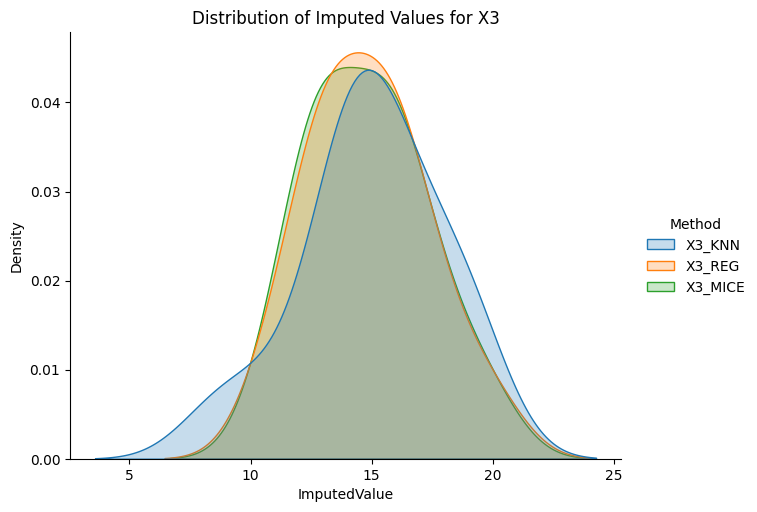

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt your three columns into one
df_melt = null_df[['X3_KNN', 'X3_REG', 'X3_MICE']].melt(
    value_name='ImputedValue', 
    var_name='Method'
)

# Now create a displot using KDE or histogram
sns.displot(
    data=df_melt, 
    x='ImputedValue', 
    hue='Method', 
    kind='kde',   # or kind='hist' for a histogram
    fill=True,    # optional: fill the area under the KDE curve
    height=5,
    aspect=1.3
)

plt.title("Distribution of Imputed Values for X3")
plt.show()


In [29]:
complete_df = df3_res[~df3_res.X3_ORIGINAL.isna()].reset_index(drop=True)
complete_df

,X3_ORIGINAL,X3_KNN,X3_REG,X3_MICE
0,15.286131,15.286131,15.286131,15.286131
1,18.766454,18.766454,18.766454,18.766454
2,20.874416,20.874416,20.874416,20.874416
3,11.380915,11.380915,11.380915,11.380915
4,12.825990,12.825990,12.825990,12.825990
...,...,...,...,...
80,9.608953,9.608953,9.608953,9.608953
81,16.803703,16.803703,16.803703,16.803703
82,16.551490,16.551490,16.551490,16.551490
83,16.699273,16.699273,16.699273,16.699273


In [31]:
# Training data for X3
X3_train = complete_df[["X3_KNN","X3_REG","X3_MICE"]]
y3_train = complete_df["X3_ORIGINAL"]

# Fit a linear regression for X3
model3 = LinearRegression()
model3.fit(X3_train, y3_train)

LinearRegression()

In [32]:
# Predict missing X3
null_df["PREDICTED"] = model3.predict(
    null_df[["X3_KNN","X3_REG","X3_MICE"]])

In [33]:
null_df

,X3_ORIGINAL,X3_KNN,X3_REG,X3_MICE,PREDICTED
0,NaN,15.762649,15.744188,15.365870,15.624236
1,NaN,19.203188,18.002623,18.096708,18.434173
2,NaN,14.437519,13.469888,13.470637,13.792682
3,NaN,8.635692,10.752932,10.954740,10.114455
4,NaN,13.620794,13.095096,13.128949,13.281613
5,NaN,13.354232,13.696587,13.562772,13.537864
6,NaN,10.765290,11.781567,11.911937,11.486265
7,NaN,14.197927,13.417934,12.966296,13.527386
8,NaN,18.111668,17.251613,17.197971,17.520418
9,NaN,13.626708,12.647346,12.370523,12.881526


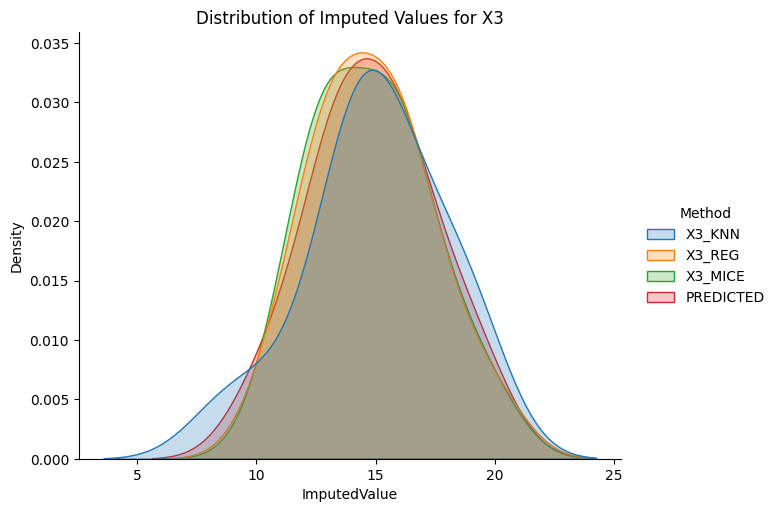

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt your three columns into one
df_melt = null_df[['X3_KNN', 'X3_REG', 'X3_MICE','PREDICTED']].melt(
    value_name='ImputedValue', 
    var_name='Method'
)

# Now create a displot using KDE or histogram
sns.displot(
    data=df_melt, 
    x='ImputedValue', 
    hue='Method', 
    kind='kde',   # or kind='hist' for a histogram
    fill=True,    # optional: fill the area under the KDE curve
    height=5,
    aspect=1.3
)

plt.title("Distribution of Imputed Values for X3")
plt.show()
